In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.providers.fake_provider import GenericBackendV2

from qiskit_device_benchmarking.bench_code.mrb import MirrorQA, QuantumAwesomeness

# custom noisy backend (or an attempt at one, at least)
class NoisyBackend(GenericBackendV2):
    def __init__(
        self,
        num_qubits: int,
        basis_gates: list[str] | None = None,
        coupling_map: list[list[int]] = None,
        p1: float = 0,
        p2: float = 0,
    ):
        self.p = (p1,p2)
        super().__init__(
            num_qubits,
            basis_gates,
            coupling_map=coupling_map,
            noise_info = (p1>0 or p2 >0)
            )
    def _get_noise_defaults(self, name: str, num_qubits: int) -> tuple:
        if name in ['delay', 'reset']:
            return (self.p[0],self.p[0])
        else:
            if num_qubits == 1:
                return (0,0,self.p[0],self.p[0])
            else:
                return (0,0,self.p[1],self.p[1])


We'll look at Quantum Awesomeness on either a real 127 qubit device, or a small emulated backend.

In [2]:
real_device = False

if real_device:
    from qiskit_ibm_provider import IBMProvider
    provider = IBMProvider(instance="ibm-q/open/main")
    backend = provider.get_backend('ibm_sherbrooke')
else:
    p = 1e-2
    backend = NoisyBackend(
    num_qubits=8,
    basis_gates = ["id", "h", "x", "y", "z", "rx", "cx"],
    p1=p/10,
    p2=p,
    )

First we set up the experiment. 

Some notes on parameters:
* `range(backend.num_qubits)`: We use the whole device.
* `two_qubit_gate_density=0.25`: Having around half of all qubits involved in an entangling gate seems like a good fraction, and this makes that happen.
* `initial_entangling_angle=np.pi/2`: Default angle is `np.pi/2`, which creates maximally entangled pairs. We'll use `np.pi/2` so we can more easily see the gates when looking at the circuits.
* `num_samples=20`: Number of different sets of random Clifford circuits.

In [3]:
# number of shots per circuit
shots = 10000

# lengths of different mirror circuits to run
lengths = [2]+[4,10,20,50,100]

# set up the experiment object
exp = MirrorQA(
    range(backend.num_qubits),
    lengths,
    backend=backend,
    two_qubit_gate_density=0.25,
    num_samples=20,
    initial_entangling_angle=np.pi/4,
    )
exp.set_run_options(
    shots=shots
)


Now we run it!

In [4]:
#run
rb_data = exp.run()
print(rb_data.job_ids)

['d0ee5e7a-32d6-47e2-824c-0c87db1728d7']


/Users/woottonjames/Library/CloudStorage/GoogleDrive-james@mothquantum.com/My Drive/Repos/qiskit-device-benchmarking/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'execution': {'meas_type': 'classified'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


To see what circuits were run, don't use `exp.circuits()` because that will set up a new bunch of circuits. Instead use `exp._static_trans_circuits`, which stores the transpiled circuits that were run.

There are two differences between MQA circuits and MRB circuits:
* MQA places the new layers of the sequence at the beginning and end, whereas MRB places them in the middle.
* MQA inserts `rx` gates on the control qubit of any qubit involved in a CX in the first layer. Leading to entanglement for all pairs involved in a CX in the first layer.

To see what pairs were used for the CX gates in the first layer of each circuit, use `exp._pairs`.

Below are the first two lengths of circuit for the first sequence of random Cliffords. The `Rx(π/4)` gates here are those inserted to create the entangled pairs.

In [5]:
print('Pairs:', exp._pairs[0])
exp._static_trans_circuits[0].draw(fold=-1)

Pairs: []


global phase: π/2
        ┌───┐ ░ ┌─────────┐   ┌───┐    ┌───┐ ░ ┌───┐ ░    ┌───┐   ┌──────────┐┌───┐      ░ ┌───┐ ░  ░ ┌─┐                     
   q_0: ┤ Y ├─░─┤ Rx(π/2) ├───┤ H ├────┤ X ├─░─┤ X ├─░────┤ H ├───┤ Rx(-π/2) ├┤ Y ├──────░─┤ X ├─░──░─┤M├─────────────────────
        ├───┤ ░ └──┬───┬──┘   └───┘    └───┘ ░ ├───┤ ░    ├───┤   └──────────┘└───┘      ░ ├───┤ ░  ░ └╥┘┌─┐                  
   q_1: ┤ X ├─░────┤ H ├─────────────────────░─┤ X ├─░────┤ H ├──────────────────────────░─┤ Y ├─░──░──╫─┤M├──────────────────
        ├───┤ ░ ┌──┴───┴──┐   ┌───┐          ░ ├───┤ ░    ├───┤   ┌──────────┐           ░ └───┘ ░  ░  ║ └╥┘┌─┐               
   q_2: ┤ Y ├─░─┤ Rx(π/2) ├───┤ H ├──────────░─┤ Z ├─░────┤ H ├───┤ Rx(-π/2) ├───────────░───────░──░──╫──╫─┤M├───────────────
        ├───┤ ░ └──┬───┬──┘   └───┘          ░ ├───┤ ░    ├───┤   └──────────┘           ░ ┌───┐ ░  ░  ║  ║ └╥┘┌─┐            
   q_3: ┤ X ├─░────┤ Y ├─────────────────────░─┤ X ├─░────┤ Y ├──────────────────────────░─┤ Y ├─░──░──╫──╫──╫─┤M├────────────
        ├───┤ ░    ├───┤   ┌──────────┐      ░ ├───┤ ░ ┌──┴───┴──┐   ┌───┐               ░ ├───┤ ░  ░  ║  ║  ║ └╥┘┌─┐         
   q_4: ┤ X ├─░────┤ H ├───┤ Rx(-π/2) ├──────░─┤ Z ├─░─┤ Rx(π/2) ├───┤ H ├───────────────░─┤ Z ├─░──░──╫──╫──╫──╫─┤M├─────────
        ├───┤ ░    ├───┤   ├─────────┬┘┌───┐ ░ ├───┤ ░ └──┬───┬──┘┌──┴───┴──┐ ┌───┐┌───┐ ░ ├───┤ ░  ░  ║  ║  ║  ║ └╥┘┌─┐      
   q_5: ┤ Y ├─░────┤ H ├───┤ Rx(π/2) ├─┤ H ├─░─┤ X ├─░────┤ H ├───┤ Rx(π/2) ├─┤ H ├┤ Z ├─░─┤ X ├─░──░──╫──╫──╫──╫──╫─┤M├──────
        ├───┤ ░    ├───┤   ├─────────┴┐└───┘ ░ ├───┤ ░ ┌──┴───┴──┐└──┬───┬──┘ └───┘└───┘ ░ ├───┤ ░  ░  ║  ║  ║  ║  ║ └╥┘┌─┐   
   q_6: ┤ Y ├─░────┤ H ├───┤ Rx(-π/2) ├──────░─┤ Z ├─░─┤ Rx(π/2) ├───┤ H ├───────────────░─┤ X ├─░──░──╫──╫──╫──╫──╫──╫─┤M├───
        ├───┤ ░    ├───┤   └──────────┘      ░ ├───┤ ░ └──┬───┬──┘   └───┘               ░ ├───┤ ░  ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
   q_7: ┤ X ├─░────┤ Z ├─────────────────────░─┤ X ├─░────┤ Z ├──────────────────────────░─┤ Y ├─░──░──╫──╫──╫──╫──╫──╫──╫─┤M├
        └───┘ ░    └───┘                     ░ └───┘ ░    └───┘                          ░ └───┘ ░  ░  ║  ║  ║  ║  ║  ║  ║ └╥┘
meas: 8/═══════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩═
                                                                                                       0  1  2  3  4  5  6  7

In [6]:
print('Pairs:', exp._pairs[1])
exp._static_trans_circuits[1].draw(fold=-1)

Pairs: [(2, 6)]


global phase: π/2
        ┌───┐ ░ ┌──────────┐   ┌───┐                           ░       ░ ┌─────────┐   ┌───┐    ┌───┐ ░ ┌───┐ ░    ┌───┐   ┌──────────┐┌───┐      ░ ┌───┐ ░ ┌──────────┐   ┌───┐                         ░ ┌───┐ ░  ░ ┌─┐                     
   q_0: ┤ Y ├─░─┤ Rx(-π/2) ├───┤ Z ├───────────────────────────░───────░─┤ Rx(π/2) ├───┤ H ├────┤ X ├─░─┤ X ├─░────┤ H ├───┤ Rx(-π/2) ├┤ Y ├──────░─┤ X ├─░─┤ Rx(-π/2) ├───┤ Z ├─────────────────────────░─┤ X ├─░──░─┤M├─────────────────────
        ├───┤ ░ └──┬───┬───┘┌──┴───┴───┐   ┌───┐               ░       ░ └──┬───┬──┘   └───┘    └───┘ ░ ├───┤ ░    ├───┤   └──────────┘└───┘      ░ ├───┤ ░ ├─────────┬┘   ├───┤      ┌───┐              ░ ├───┤ ░  ░ └╥┘┌─┐                  
   q_1: ┤ X ├─░────┤ H ├────┤ Rx(-π/2) ├───┤ Z ├───────────────░───────░────┤ H ├─────────────────────░─┤ Z ├─░────┤ H ├──────────────────────────░─┤ X ├─░─┤ Rx(π/2) ├────┤ H ├──────┤ Y ├──────────────░─┤ Y ├─░──░──╫─┤M├──────────────────
        ├───┤ ░    └───┘    ├─────────┬┘   └───┘               ░ ┌───┐ ░ ┌──┴───┴──┐   ┌───┐          ░ ├───┤ ░    ├───┤   ┌──────────┐           ░ ├───┤ ░ └─────────┘    └───┘      └───┘              ░ └───┘ ░  ░  ║ └╥┘┌─┐               
   q_2: ┤ Y ├─░──────■──────┤ Rx(π/4) ├────────────────────────░─┤ X ├─░─┤ Rx(π/2) ├───┤ H ├──────────░─┤ Y ├─░────┤ H ├───┤ Rx(-π/2) ├───────────░─┤ Z ├─░──────■───────────────────────────────────────░───────░──░──╫──╫─┤M├───────────────
        ├───┤ ░      │      └──┬───┬──┘ ┌──────────┐┌───┐      ░ ├───┤ ░ └──┬───┬──┘   └───┘          ░ └───┘ ░    ├───┤   └──────────┘           ░ ├───┤ ░      │      ┌─────────┐   ┌───┐   ┌───┐      ░ ┌───┐ ░  ░  ║  ║ └╥┘┌─┐            
   q_3: ┤ X ├─░──────┼─────────┤ H ├────┤ Rx(-π/2) ├┤ X ├──────░─┤ Y ├─░────┤ Y ├─────────────────────░───────░────┤ Y ├──────────────────────────░─┤ X ├─░──────┼──────┤ Rx(π/2) ├───┤ H ├───┤ Z ├──────░─┤ Y ├─░──░──╫──╫──╫─┤M├────────────
        ├───┤ ░      │         ├───┤    ├─────────┬┘├───┤┌───┐ ░ ├───┤ ░    ├───┤   ┌──────────┐      ░ ┌───┐ ░ ┌──┴───┴──┐   ┌───┐               ░ ├───┤ ░      │      └──┬───┬──┘┌──┴───┴──┐├───┤┌───┐ ░ ├───┤ ░  ░  ║  ║  ║ └╥┘┌─┐         
   q_4: ┤ X ├─░──────┼─────────┤ H ├────┤ Rx(π/2) ├─┤ H ├┤ Y ├─░─┤ X ├─░────┤ H ├───┤ Rx(-π/2) ├──────░─┤ Y ├─░─┤ Rx(π/2) ├───┤ H ├───────────────░─┤ Z ├─░──────┼─────────┤ H ├───┤ Rx(π/2) ├┤ H ├┤ Y ├─░─┤ Z ├─░──░──╫──╫──╫──╫─┤M├─────────
        ├───┤ ░      │         ├───┤    └──┬───┬──┘ └───┘└───┘ ░ ├───┤ ░    ├───┤   ├─────────┬┘┌───┐ ░ ├───┤ ░ └──┬───┬──┘┌──┴───┴──┐ ┌───┐┌───┐ ░ ├───┤ ░      │         ├───┤   └──┬───┬──┘└───┘└───┘ ░ ├───┤ ░  ░  ║  ║  ║  ║ └╥┘┌─┐      
   q_5: ┤ Y ├─░──────┼─────────┤ H ├───────┤ X ├───────────────░─┤ X ├─░────┤ H ├───┤ Rx(π/2) ├─┤ H ├─░─┤ X ├─░────┤ H ├───┤ Rx(π/2) ├─┤ H ├┤ Z ├─░─┤ X ├─░──────┼─────────┤ H ├──────┤ Z ├──────────────░─┤ X ├─░──░──╫──╫──╫──╫──╫─┤M├──────
        ├───┤ ░    ┌─┴─┐       └───┘       └───┘               ░ ├───┤ ░    ├───┤   ├─────────┴┐└───┘ ░ ├───┤ ░ ┌──┴───┴──┐└──┬───┬──┘ └───┘└───┘ ░ ├───┤ ░    ┌─┴─┐       └───┘      └───┘              ░ ├───┤ ░  ░  ║  ║  ║  ║  ║ └╥┘┌─┐   
   q_6: ┤ Y ├─░────┤ X ├───────────────────────────────────────░─┤ X ├─░────┤ H ├───┤ Rx(-π/2) ├──────░─┤ X ├─░─┤ Rx(π/2) ├───┤ H ├───────────────░─┤ Z ├─░────┤ X ├─────────────────────────────────────░─┤ X ├─░──░──╫──╫──╫──╫──╫──╫─┤M├───
        ├───┤ ░    ├───┤       ┌───┐                           ░ ├───┤ ░    ├───┤   └──────────┘      ░ └───┘ ░ └──┬───┬──┘   └───┘               ░ ├───┤ ░    ├───┤       ┌───┐                         ░ ├───┤ ░  ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
   q_7: ┤ X ├─░────┤ H ├───────┤ Z ├───────────────────────────░─┤ Y ├─░────┤ Z ├─────────────────────░───────░────┤ Z ├──────────────────────────░─┤ X ├─░────┤ H ├───────┤ X ├─────────────────────────░─┤ Y ├─░──░──╫──╫──╫──╫──╫──╫──╫─┤M├
        └───┘ ░    └───┘       └───┘                           ░ └───┘ ░    └───┘                     ░       ░    └───┘                          ░ └───┘ ░   

Now we can analyze the data according to our desired analysis method.

In [7]:
exp.analysis.set_options(analyzed_quantity='Effective Polarization')
#exp.analysis.set_options(analyzed_quantity='Mutual Information')
analysis = exp.analysis.run(rb_data)

Then plot the results.

Note: if you get the `'Figure index 0 out of range.'` error, it might be because the analysis is still running in the background. So just try again.

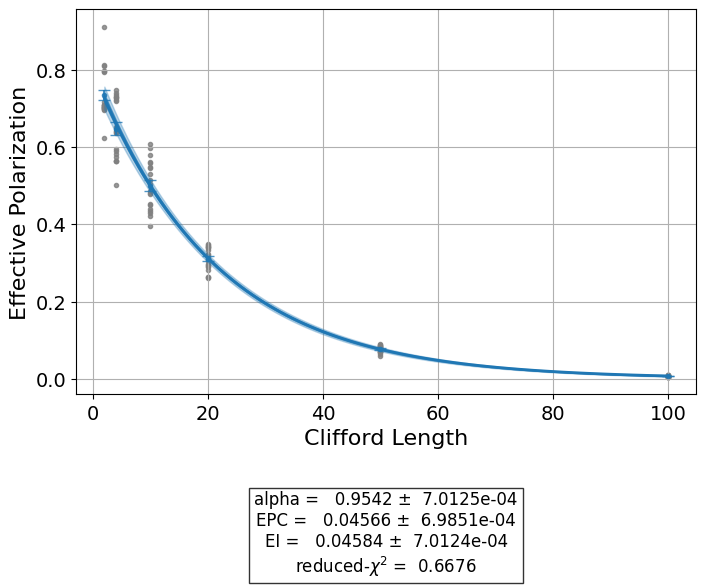

In [8]:
analysis.figure(0)

When we calculate the mutual informations, it is done by the `QuantumAwesomeness` object. We can also use this directly.

In [9]:
qa = QuantumAwesomeness(exp.backend.coupling_map)

It can be used to calculate the MIs for each pair in the coupling map for each circuit that was run.

In [10]:
mi = qa.mutual_info(rb_data.data())

It can also be used to calculate the mean MIs, where separate means are taken for the entangled pairs and the non-entangled pairs.

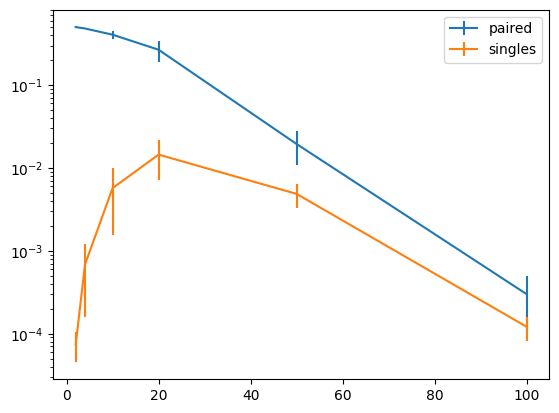

In [12]:
mmi = qa.mean_mutual_info(rb_data.data(), exp._pairs)

ys = [[[] for _ in range(6)] for _ in range(2)]
yerrs = [[],[]]

for p, pairtype in enumerate(['paired', 'single']):
    for j,m in enumerate(mmi[pairtype]):
        if m is not np.nan:
            ys[p][j%6].append(m)
    for j in range(6):
        yerrs[p].append(np.std(ys[p][j]))
        ys[p][j] = np.mean(ys[p][j])

plt.errorbar(lengths,ys[0],yerr=yerrs[0],label='paired')
plt.errorbar(lengths,ys[1],yerr=yerrs[1],label='singles')
plt.yscale('log')
plt.legend()

Pickled results from a run on `'ibm_sherbrooke'`can be found in the following files.

* `exp`: `'pickled_sherbrooke/exp_c0cc1667-c4da-475d-86c5-f85771ad4ce5.p'`
* `data`: `'pickled_sherbrooke/data_c0cc1667-c4da-475d-86c5-f85771ad4ce5.p'`
* `data.data()`: `'pickled_sherbrooke/data_data_c0cc1667-c4da-475d-86c5-f85771ad4ce5.p'`
* `mi`: `'pickled_sherbrooke/mi_c0cc1667-c4da-475d-86c5-f85771ad4ce5.p'`

